# Lec04. Image Augmentation(이미지 증강)

ref: https://keras.io/api/preprocessing/image/

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

In [42]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation            # FC
from keras.layers import Conv2D, MaxPooling2D,Flatten # CNN

from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint # callback

# ------------------- seed 고정 -----------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [43]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image

In [44]:
from keras.datasets import fashion_mnist

## 이미지 증강 위해서는 3단 구조 구성해야 함.

<pre>
main_directory/           ---------- 최상위 폴더
...class_a/               ----------  ㄴ 서브폴더 : 븐류클래스
......a_image_1.jpg       ----------    ㄴ 관련 이미지
......a_image_2.jpg       ----------    ㄴ 관련 이미지
...class_b/
......b_image_1.jpg
......b_image_2.jpg

# data

In [45]:
# api에는 tensorflow.keras 쓰도록 되어있지만 keras가 떨어져 나와서 tensorflow 없어도 됨.
from keras.datasets import mnist # toydataset. 누구나 거쳐가는 데이터

In [46]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() # keras에서 load_data는 train, test set 나눠서 한다.

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [48]:
pd.Series(y_train).value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

# EDA

(60000, 28, 28)


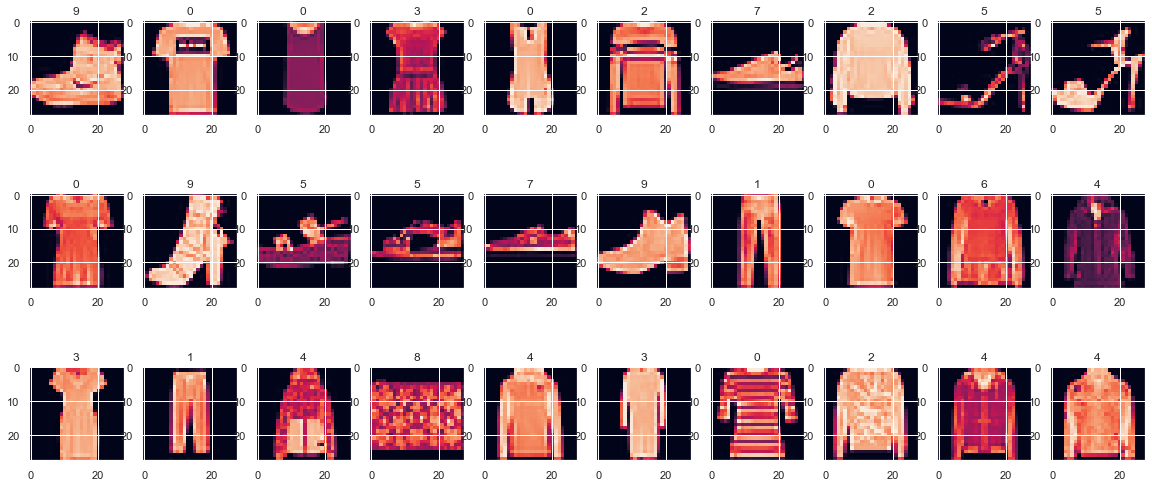

In [66]:
# import matplotlib.pyplot as plt
p, axes = plt.subplots(3,10,figsize=(20,9))

print(X_train.shape)
X_train.shape[0]
for i in range(30): # range(X_train[:30].shape[0]) 해도 된다.
    row=i//10
    col=i%10
    axes[row,col].imshow(X_train[i])#, cmap=plt.get_cmap('gray'))
    axes[row,col].set_title(y_train[i])
plt.show()

In [50]:
label = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# X데이터 가공

* <font color=red><b>CNN 모델 : shape(장수,H,W,컬러)</b></font>

In [51]:
X_train_img=X_train.reshape(-1,28,28,1)
X_test_img=X_test.reshape(-1,28,28,1)

In [52]:
X_train_img.shape

(60000, 28, 28, 1)

In [53]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [54]:
# X_train = X_train.reshape(X_train.shape[0], 784) # 784=28*28
# X_test = X_test.reshape(X_test.shape[0], 784) # 784=28*28

In [55]:
X_train_scaled=X_train_img/255.0
X_test_scaled=X_test_img/255.0

# y label 평준화
y_label : integers in range 0-9

<pre>
* ML : arr.LabelEncoder() 글->숫, arr.OneHotEncoder() 1 0 0 0 ... df.get_dummies() 결측처리, 글->숫, 원핫

In [56]:
y_train_oh=to_categorical(y=y_train, num_classes=10, dtype='int32') # class 숫자 찍어줘야함
y_test_oh=to_categorical(y=y_test, num_classes=10, dtype='int32')

# CNN Model 구축

In [57]:
INPUT_SHAPE__ = (28,28,1)           # ------------------ 주의주의주의(장수는 관련 없다.)
NUM_CLASS__= 10                     # ------------------ 총 10개로 분류
ACTIVATION__ = "softmax"            # ------------------ 또는 sigmoid
LOSS__ = 'categorical_crossentropy' # ------------------ binary_crossentropy, sparse_crossentropy

model = Sequential([
    # ---------- CNN -------------
    Conv2D(16, kernel_size=(3,3), input_shape=INPUT_SHAPE__, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),


    # ---------FC(Affine) --------
    Dense(units=128 , activation='relu'),
    Dense(units=10 , activation=ACTIVATION__) # 다중분류 예측(0~9)

])

model.compile(loss=LOSS__ , # logloss라고 써도 된다.
             optimizer='adam',
             metrics='accuracy')

In [58]:
# model.summary()

# 학습 & 평가

<font color=red size=4>callbacks: https://keras.io/api/callbacks/</font>

* Write TensorBoard logs after every batch of training to monitor your metrics  
* <font color=red>Periodically save your model to disk</font>-----------------------------------------------모델 저장  
* <font color=red>Do early stopping</font>------------------------------------------------------------------오버피팅 시 조기 종료  
* Get a view on internal states and statistics of a model during training

In [59]:
EPOCHS__ = 10
BATCH_SIZE__ = 128
PATIENCE__ = 5

In [60]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [61]:
MY_CALLBACKS__ = [
    EarlyStopping(patience=PATIENCE__), # 점수 더 좋아질 기미 안 보이면 stop. patience동안 점수 안 좋으면 멈춘다.
    ModelCheckpoint(filepath='./model/mymodel.{epoch:02d}-{val_loss:.4f}.h5') # 이전 epoch보다 현재가 점수 더 좋으면 mydoel_03_.2417.h5
]

In [63]:
res=model.fit(X_train_scaled,
              y_train_oh,
              epochs=EPOCHS__,
              batch_size=BATCH_SIZE__,   # 128바이트씩 끊어서 읽어라
              validation_split=0.1,
              callbacks=MY_CALLBACKS__
                )

Epoch 1/10
422/422 [==============================] - 9s 19ms/step - loss: 0.6468 - accuracy: 0.7697 - val_loss: 0.4646 - val_accuracy: 0.8253
Epoch 2/10
422/422 [==============================] - 8s 18ms/step - loss: 0.4069 - accuracy: 0.8532 - val_loss: 0.3769 - val_accuracy: 0.8627
Epoch 3/10
422/422 [==============================] - 8s 19ms/step - loss: 0.3598 - accuracy: 0.8696 - val_loss: 0.3399 - val_accuracy: 0.8768
Epoch 4/10
422/422 [==============================] - 8s 20ms/step - loss: 0.3311 - accuracy: 0.8801 - val_loss: 0.3251 - val_accuracy: 0.8852
Epoch 5/10
422/422 [==============================] - 9s 21ms/step - loss: 0.3133 - accuracy: 0.8862 - val_loss: 0.3343 - val_accuracy: 0.8748
Epoch 6/10
422/422 [==============================] - 9s 20ms/step - loss: 0.2966 - accuracy: 0.8916 - val_loss: 0.3153 - val_accuracy: 0.8858
Epoch 7/10
422/422 [==============================] - 9s 20ms/step - loss: 0.2808 - accuracy: 0.8979 - val_loss: 0.3082 - val_accuracy: 0.8875

In [64]:
loss_cateforical_crossentropy, metrics_accuracy = model.evaluate(X_test, y_test) 

ValueError: in user code:

    File "c:\ai\pythonproject\venv\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\engine\training.py", line 1473, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\ai\pythonproject\venv\lib\site-packages\keras\backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


# 평가 시각화

In [ ]:
plt.plot(np.arange(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 빨간 선과 파란 선 벌어져야 오버핏인데 별로 안 벌어진다.
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='accuracy')
plt.plot(np.arange(len(res.history['val_accuracy'])), res.history['val_accuracy'], c='blue', label='val_accuracy')
plt.legend()
plt.show()

# colab으로 이동